<a href="https://colab.research.google.com/github/guilhermer1/mvp_Machine_Learning_Laliga/blob/main/Laliga_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: Machine Learning & Analytics

**Autor**: Guilherme Mendes Ribeiro

**Data**: 25/09/2025

**Matrícula:** 4052025000053

**Dataset:** [LaLiga Matches Dataset (2019-2025, FBref)](https://www.kaggle.com/datasets/marcelbiezunski/laliga-matches-dataset-2019-2025-fbref)

# Descrição do Dataset

O Dataset escolhido é o LaLiga Matches Dataset (2019-2025, FBref), se trata de um conjunto de dados sobre resultados de partidas que ocorreram na primeira divisão da La Liga (Liga espanhola de Futebol). O objetivo é analisar resultados e performances dos times de 2019 a 2025 e verificar se há a possibilidade de prever resultados comparando os dados históricos de diversos times ao logo desses anos.




## 1. Definição do Problema

**Descrição do problema**

O objetivo é analisar partidas da LaLiga para entender fatores que influenciam resultados (vitória/empate/derrota) e construir modelos preditivos. O notebook foca em:
- análise exploratória (entender distribuições e missing values);
- preparar features temporais (rolling averages por time);
- treinar modelos respeitando ordem temporal (TimeSeriesSplit);
- otimizar hiperparâmetros e avaliar em conjunto de teste temporal.

**Hipóteses**
- Métricas ofensivas (gols, chutes, xG) aumentam probabilidade de vitória;
- Mando de campo (home/away) tem efeito estatisticamente relevante;
- Rolling features (forma das últimas N partidas) aumentam performance preditiva.

**Restrições**
- Evitar vazamento temporal: divisão por datas e validação temporal.
- Não utilizar variáveis derivadas do resultado futuro na construção de features.

**Descrição do dataset**

- Linhas: partidas (n = ~4318)

**Colunas:**

- Unnamed: 0
- date
- time
- comp
- round
- day
- venue
- result
- gf
- ga
- opponent
- xg
- xga
- poss
- attendance
- captain
- formation
- opp formation
- referee
- match report
- notes
- sh
- sot
- dist
- fk
- pk
- pkatt
- season
- team

### 1.1 Import das bibliotecas utilizadas

In [77]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, make_scorer, confusion_matrix

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, learning_curve

import joblib

## 2. Dados: carga, entendimento e qualidade

In [78]:
url = 'https://raw.githubusercontent.com/guilhermer1/mvp_AnaliseDeDados/refs/heads/main/matches_full.csv'

## Uma vez que os dados vão ser lidos diretamente de um CSV, o dataset já é um dataframe.
df = pd.read_csv(url, low_memory=False)
print('Arquivo carregado:', url)
print('Shape:', df.shape)
display(df.head())

Arquivo carregado: https://raw.githubusercontent.com/guilhermer1/mvp_AnaliseDeDados/refs/heads/main/matches_full.csv
Shape: (4318, 29)


,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,2024-08-17,21:30,La Liga,Matchweek 1,Sat,Away,W,2.0,1.0,...,Match Report,NaN,17.0,5.0,18.6,1.0,1,1,2025,Barcelona
1,1,2024-08-24,19:00,La Liga,Matchweek 2,Sat,Home,W,2.0,1.0,...,Match Report,NaN,13.0,5.0,16.6,0.0,0,0,2025,Barcelona
2,2,2024-08-27,21:30,La Liga,Matchweek 3,Tue,Away,W,2.0,1.0,...,Match Report,NaN,22.0,5.0,19.3,1.0,0,0,2025,Barcelona
3,3,2024-08-31,17:00,La Liga,Matchweek 4,Sat,Home,W,7.0,0.0,...,Match Report,NaN,23.0,11.0,13.7,1.0,0,0,2025,Barcelona
4,4,2024-09-15,16:15,La Liga,Matchweek 5,Sun,Away,W,4.0,1.0,...,Match Report,NaN,20.0,9.0,19.1,0.0,0,0,2025,Barcelona


Descrição e Relevância das Colunas do Dataset

Este dataset contém informações detalhadas sobre partidas da La Liga, essenciais para construir um modelo preditivo de resultados. Abaixo, descrevemos as colunas presentes e sua relevância para o projeto:

* **`Unnamed: 0`**: Coluna de índice original, não relevante para a análise ou modelagem e foi removida durante o pré-processamento.
* **`date`**: Data da partida. Crucial para a análise e modelagem temporal, permitindo ordenar os dados e criar features baseadas no histórico recente (`rolling features`) e dividir os dados em conjuntos de treino, validação e teste que respeitam a ordem cronológica.
* **`time`**: Horário da partida. Embora não utilizada diretamente nas features atuais, poderia ser relevante para análises futuras (ex: impacto de jogos noturnos vs diurnos).
* **`comp`**: Competição (neste caso, 'La Liga'). Essencial para garantir que estamos analisando apenas jogos da liga espanhola.
* **`round`**: Rodada da competição. Pode ser útil para análises da evolução do campeonato, mas não foi usada diretamente como feature.
* **`day`**: Dia da semana da partida. Similar ao horário, não foi usada como feature, mas poderia ter relevância (ex: jogos de fim de semana vs meio de semana).
* **`venue`**: Local da partida (Home/Away). **Feature importante** incluída no modelo, pois o mando de campo é um fator conhecido por influenciar o desempenho das equipes.
* **`result`**: Resultado da partida (W/D/L). O resultado na perspectiva do time na linha. Esta coluna foi usada para derivar a variável target binária (`target_binary`).
* **`gf`**: Gols a favor do time na linha. Usado para calcular o `target_binary` e como base para a feature `rolling_gf_team`.
* **`ga`**: Gols contra o time na linha. Usado para calcular o `target_binary` e como base para a feature `rolling_ga_team`.
* **`opponent`**: Adversário na partida. Essencial para identificar os confrontos, embora não tenha sido usada diretamente como feature no modelo atual (poderia ser útil para features como histórico de confrontos).
* **`xg`**: Gols Esperados (Expected Goals) para o time na linha. **Feature importante** que mede a qualidade das chances de gol criadas. Alta correlação com `gf`.
* **`xga`**: Gols Sofridos Esperados (Expected Goals Against) para o time na linha. **Feature importante** que mede a qualidade das chances de gol cedidas ao adversário. Alta correlação com `ga`.
* **`poss`**: Posse de bola do time na linha. **Feature importante** que reflete o controle do jogo.
* **`attendance`**: Público presente na partida. Não relevante para a previsão de resultado baseada em métricas de jogo e foi removida devido a valores ausentes.
* **`captain`**: Capitão do time na linha. Não relevante para este modelo e não utilizada.
* **`formation`**: Formação tática do time na linha. Não utilizada, mas poderia ser uma feature interessante para explorar em modelos mais complexos.
* **`opp formation`**: Formação tática do adversário. Similar à `formation`.
* **`referee`**: Árbitro da partida. Não utilizada devido a valores ausentes e por não ser considerada uma feature primária para este modelo.
* **`match report`**: Link para o relatório da partida. Metadado, não utilizado como feature.
* **`notes`**: Notas adicionais. Muitos valores ausentes, não relevante para o modelo e foi removida.
* **`sh`**: Chutes a gol do time na linha. **Feature importante** que reflete a atividade ofensiva.
* **`sot`**: Chutes no alvo (Sot) do time na linha. **Feature importante**, uma métrica mais refinada de atividade ofensiva que `sh`.
* **`dist`**: Distância média dos chutes. **Feature importante** que pode indicar o tipo de finalização da equipe.
* **`fk`**: Faltas cobradas (Free Kicks). Não utilizada como feature.
* **`pk`**: Pênaltis convertidos. Não utilizada como feature.
* **`pkatt`**: Tentativas de pênalti. Não utilizada como feature.
* **`season`**: Temporada da partida. Usada para contextualizar os dados, mas não diretamente como feature (embora o `date` capture essa informação).
* **`team`**: Nome do time na linha. Crucial para criar as `rolling features` por time e para identificar os participantes da partida, embora não seja usada diretamente como feature no modelo treinado.

Em resumo, as colunas numéricas de desempenho (`xg`, `xga`, `poss`, `sh`, `sot`, `dist`), a informação temporal (`date` para `rolling features`) e o mando de campo (`venue`) são as mais relevantes e foram selecionadas como features para a construção dos modelos preditivos.

## 2.1 Análise Exploratória (EDA) - Resumida


In [79]:
# Informações gerais
print('Colunas:', df.columns.tolist())
print('\nTipos de dados:\n', df.dtypes.value_counts())

# Missing values por coluna
miss = df.isna().sum().sort_values(ascending=False)
print('\nMissing values (top 20):\n', miss.head(20))

# Estatísticas descritivas
display(df.describe(include=['int64','float64']).T.head(30))

Colunas: ['Unnamed: 0', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation', 'opp formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team']

Tipos de dados:
 object     14
float64    11
int64       4
Name: count, dtype: int64

Missing values (top 20):
 notes            4318
attendance        974
referee            54
dist                3
Unnamed: 0          0
day                 0
venue               0
result              0
gf                  0
date                0
time                0
comp                0
round               0
xga                 0
xg                  0
opponent            0
ga                  0
formation           0
captain             0
opp formation       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,4318.0,21.691524,13.893162,0.0,9.0,21.0,33.0,58.0
gf,4318.0,1.270032,1.168970,0.0,0.0,1.0,2.0,7.0
ga,4318.0,1.270032,1.168970,0.0,0.0,1.0,2.0,7.0
xg,4318.0,1.262112,0.774208,0.0,0.7,1.1,1.7,5.9
xga,4318.0,1.262112,0.774208,0.0,0.7,1.1,1.7,5.9
poss,4318.0,50.001158,11.435318,18.0,42.0,50.0,58.0,82.0
attendance,3344.0,27864.883373,18103.653603,13.0,14195.0,20123.0,39611.5,95745.0
notes,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sh,4318.0,11.512043,4.838242,0.0,8.0,11.0,14.0,36.0
sot,4318.0,3.785086,2.288167,0.0,2.0,3.0,5.0,17.0


Análise Resumida das Principais Variáveis

Com base nas informações gerais, tipos de dados, contagem de valores ausentes e estatísticas descritivas apresentadas nos outputs:

* **Tipos de Dados:** O dataset contém uma mistura de dados do tipo `object` (strings, como nomes de times, resultados, etc.), `float64` e `int64` (variáveis numéricas como gols, chutes, posse de bola). A maioria das colunas relevantes para a análise e modelagem são numéricas ou categóricas (`object`) que precisarão ser tratadas.
* **Missing Values:** As colunas `notes`, `attendance`, e `referee` possuem um número significativo de valores ausentes, o que as torna menos úteis para a modelagem direta sem um tratamento de imputação ou exclusão. A coluna `dist` também tem alguns valores ausentes (3), que precisarão ser tratados. As demais colunas essenciais parecem estar completas.
* **Estatísticas Descritivas (Variáveis Numéricas):**
    * **`gf` (Gols a Favor) e `ga` (Gols Contra):** A média de gols marcados e sofridos por partida é de aproximadamente 1.27. Os valores variam de 0 a 7 gols por partida. A distribuição parece razoavelmente simétrica em torno da média.
    * **`xg` (Gols Esperados) e `xga` (Gols Sofridos Esperados):** As médias de `xg` e `xga` são próximas à média de gols reais (cerca de 1.26), o que sugere que estas métricas de expectativa de gol refletem bem a realidade dos gols marcados/sofridos no dataset. Os valores de `xg` e `xga` variam de 0 a 5.9.
    * **`poss` (Posse de Bola):** A posse média é de 50%, como esperado, já que a posse de bola é dividida entre os dois times. A variação é considerável (de 18% a 82%), indicando que há jogos com domínio claro de posse de bola por um dos lados.
    * **`sh` (Chutes) e `sot` (Chutes no Alvo):** A média de chutes é de cerca de 11.5 por partida, com uma média de 3.8 chutes no alvo. Isso sugere que, em média, cerca de um terço dos chutes vão na direção do gol. Estas são métricas importantes da atividade ofensiva.
    * **`dist` (Distância Média dos Chutes):** A distância média dos chutes é de aproximadamente 18.2 metros. Isso pode indicar o tipo de chances criadas (mais chutes de perto vs de longe).
    * **`pk` (Pênaltis Convertidos) e `pkatt` (Tentativas de Pênalti):** As médias são baixas (0.13 e 0.17), indicando que pênaltis são eventos relativamente raros por partida, mas podem ser relevantes quando ocorrem.
* **Variáveis Categóricas (`object`):** Colunas como `venue` (Home/Away), `result` (W/D/L), `team`, `opponent`, `day`, `round`, `comp`, `formation`, `opp formation`, `captain`, `match report` são categóricas. `venue`, `result`, `team`, `opponent` são particularmente importantes para o problema de previsão e a construção de features.

Em resumo, a análise inicial revela que o dataset está relativamente limpo nas colunas de desempenho essenciais, mas requer tratamento de valores ausentes em algumas colunas e a conversão/codificação de variáveis categóricas para serem utilizadas nos modelos. As estatísticas descritivas mostram distribuições plausíveis para as métricas de jogo, que serão a base para as features preditivas.

In [80]:
## Excluindo a coluna Unnamed: 0, Attendance, Notes e referee pela presença de valores nulos e irrelevância na análise.

df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('notes', axis=1, inplace=True)
df.drop('referee', axis=1, inplace=True)
df.drop('attendance', axis=1, inplace=True)

# Missing values por coluna
miss = df.isna().sum().sort_values(ascending=False)
print('\nMissing values (top 20):\n', miss.head(20))



Missing values (top 20):
 dist             3
time             0
comp             0
round            0
day              0
venue            0
result           0
gf               0
date             0
ga               0
opponent         0
xga              0
xg               0
captain          0
formation        0
opp formation    0
poss             0
match report     0
sh               0
sot              0
dtype: int64


A exclusão das colunas **(Attendance, Notes e referee)** foi necessária apra obtermos um Dataset mais limpo, uma vez que eram as colunas que apresentavam valores nulos ou faltantes.

Estes atributos não são relevantes para a criação para o modelo, por essa razão, não faz sentido manter missing values e colunas desnecessárias no dataset.

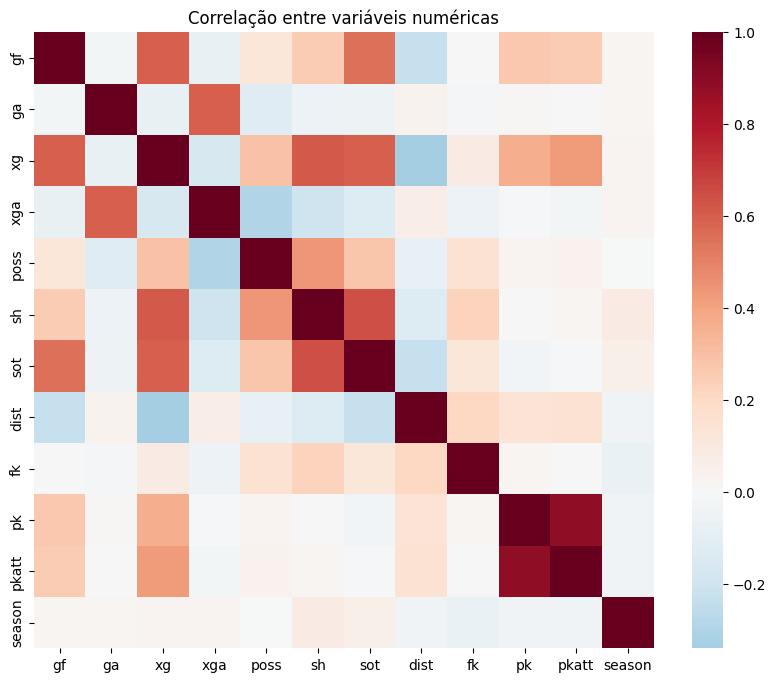

In [81]:
# Matriz de correlação (numéricas)

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap='RdBu_r', center=0, annot=False, fmt='.2f')
plt.title('Correlação entre variáveis numéricas')
plt.show()

O gráfico acima demonstra a matriz de correlação entre as variáveis numéricas do dataset.

Cada quadrado na matriz representa a correlação entre duas variáveis. A cor do quadrado indica a força e a direção da correlação:

*   Cores quentes (vermelho/laranja) indicam correlação positiva (quando uma variável aumenta, a outra tende a aumentar também).
*   Cores frias (azul) indicam correlação negativa (quando uma variável aumenta, a outra tende a diminuir).
*   Quanto mais intensa a cor (longe do branco/cinza), mais forte a correlação.

A diagonal principal (do canto superior esquerdo ao canto inferior direito) mostra a correlação de cada variável consigo mesma, que é sempre 1 (correlação perfeita).

Com base no gráfico, algumas variáveis que se destacam pela relação com a quantidade de gols feitos são:

- xg -> Gols Esperados
- xga -> Gols Sofridos Esperados
- poss -> Posse de bola
- sh -> Chutes
- sot -> Chutes ao GOl


## 4. Definição do target, variáveis e divisão dos dados

Com base na descrição do problema, onde o objetivo é prever o resultado de uma partida (vitória, empate ou derrota), este se trata de um problema de **Classificação**.

Isso ocorre porque a variável alvo que estamos tentando prever (`result`) é categórica, ou seja, assume um conjunto finito de valores discretos (W, D, L representando vitória, empate e derrota, respectivamente). Modelos de classificação são utilizados para atribuir uma amostra a uma categoria específica.

Para um modelo baseline, podemos considerar algoritmos de classificação mais simples e com bom desempenho em diversos cenários, como:

*   **Logistic Regression:** Um modelo linear simples e interpretável.
*   **Random Forest Classifier:** Um modelo de ensemble que geralmente entrega boa performance.


In [82]:
# Distribuição do target (ex.: 'result' se existir)
if 'result' in df.columns:
    print('Distribuição de result:')
    print(df['result'].value_counts(normalize=True))
else:
    # se não houver 'result', usar gf/ga para criar
    print('Coluna `result` não encontrada; criando a partir de gf / ga (gols a favor/sofridos) se presentes.')
    if 'gf' in df.columns and 'ga' in df.columns:
        df['result_calc'] = np.where(df['gf']>df['ga'], 'win', np.where(df['gf']==df['ga'], 'draw','loss'))
        print(df['result_calc'].value_counts(normalize=True))

Distribuição de result:
result
W    0.362668
L    0.362668
D    0.274664
Name: proportion, dtype: float64


In [83]:
# Criar target e converter datas

# Exemplo: se existir gf (gols a favor) e ga (gols contra), usar como referência
if 'gf' in df.columns and 'ga' in df.columns:
    df['result'] = np.where(df['gf']>df['ga'], 'home_win', np.where(df['gf']==df['ga'],'draw','away_win'))
    # binário para exemplo: home_win vs not_home_win
    df['target_binary'] = (df['gf']>df['ga']).astype(int)
    print('Target criado a partir de gf/ga.')
else:
    print('Colunas gf/ga não encontradas. Verifique o dataset.')

# Converter coluna de data se existir
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    print('Data convertida. Min/Max:', df['date'].min(), df['date'].max())
else:
    print('Coluna date não encontrada.')

# Ordenar
df = df.sort_values('date').reset_index(drop=True)

Target criado a partir de gf/ga.
Data convertida. Min/Max: 2019-08-16 00:00:00 2025-03-02 00:00:00


/tmp/ipython-input-2322721027.py:14: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')


### Definição e Criação da Variável Target

Para o nosso modelo de classificação, a variável alvo (target) é o resultado da partida. No dataset original, a coluna `result` já indica o resultado (W, D, L). No entanto, para alguns tipos de análise ou modelos, pode ser útil ter uma representação numérica ou binária do resultado.

No código acima, foram realizadas as seguintes etapas para criar a variável target:

1.  **Criação da coluna `result` (se necessário):** Embora o dataset já possua a coluna `result`, o código inclui uma verificação (`if 'gf' in df.columns and 'ga' in df.columns:`) para recriá-la a partir dos gols a favor (`gf`) e gols contra (`ga`).
    *   Se `gf` > `ga`, o resultado é considerado 'home_win'.
    *   Se `gf` == `ga`, o resultado é 'draw'.
    *   Se `gf` < `ga`, o resultado é 'away_win'.
    *   **Motivo:** Esta etapa garante que a coluna `result` esteja presente e padronizada, mesmo que o dataset original não a contivesse exatamente da mesma forma ou para criar uma versão específica do target (neste caso, separando vitória em casa, empate e vitória fora).

2.  **Criação da coluna `target_binary`:** Uma variável target binária foi criada, representando se o time da linha (o time "home" na perspectiva deste registro, mesmo que a partida seja fora) ganhou ou não.
    *   Se `gf` > `ga`, `target_binary` é 1 (vitória).
    *   Caso contrário (`gf` <= `ga`), `target_binary` é 0 (não-vitória: empate ou derrota).
    *   **Motivo:** Criar uma variável target binária simplifica o problema para um modelo de classificação binária (prever "ganha" vs "não ganha"), o que pode ser útil para análises iniciais ou para modelos que requerem um target binário.

3.  **Conversão da coluna `date`:** A coluna `date` foi convertida para o tipo datetime do pandas.
    *   **Motivo:** Converter a coluna de data é essencial para qualquer análise ou modelagem de séries temporais ou que precise considerar a ordem cronológica dos eventos, como a criação de features `rolling` (médias móveis) ou a divisão temporal dos dados.

4.  **Ordenação do DataFrame:** O DataFrame foi ordenado pela coluna `date`.
    *   **Motivo:** Ordenar os dados pela data é crucial para garantir a validade das análises temporais e, principalmente, para a aplicação correta de técnicas de validação temporal (como TimeSeriesSplit) e a criação de features baseadas em histórico (como médias móveis), evitando vazamento de informação do futuro para o passado.

Em resumo, essas etapas foram realizadas para preparar a variável que queremos prever (`result` ou `target_binary`) em formatos adequados para a modelagem, além de garantir que os dados estejam prontos para manipulações que respeitem a ordem temporal das partidas.

## 5. Tratamento de dados e **Pipeline** de pré-processamento

### 5.1 Criando uma nova Feature, Descrevendo o desempenho do Time nas últimas 5 partidas

In [84]:
# Rolling features simples: média de gf nas últimas 5 partidas por time
# O dataset tem colunas 'team' e 'opponent' conforme inspeção inicial?
if 'team' in df.columns and 'gf' in df.columns and 'ga' in df.columns:
    window = 5
    long = []
    for idx, row in df.iterrows():
        long.append({'date':row['date'],'team':row['team'],'goals_for':row['gf'],'goals_against':row['ga'],'match_id':idx})
        # se o CSV for por time já cada linha é time X opponent
    long = pd.DataFrame(long).sort_values(['team','date'])
    long['rolling_gf'] = long.groupby('team')['goals_for'].transform(lambda x: x.shift().rolling(window=window, min_periods=1).mean())
    long['rolling_ga'] = long.groupby('team')['goals_against'].transform(lambda x: x.shift().rolling(window=window, min_periods=1).mean())

    # map back
    roll_home = long.set_index('match_id')[['rolling_gf','rolling_ga']]
    df['rolling_gf_team'] = roll_home['rolling_gf']
    df['rolling_ga_team'] = roll_home['rolling_ga']
    print('Rolling features criadas.')
else:
    print('Colunas necessárias para rolling não encontradas (team/gf/ga).')

Rolling features criadas.


Criação de Features Temporais (Rolling Averages)

As colunas `rolling_gf_team` e `rolling_ga_team` foram criadas para capturar a "forma" ou o desempenho recente de cada time ao longo do tempo. Elas representam a média dos gols marcados (`rolling_gf_team`) e sofridos (`rolling_ga_team`) pelo time nas suas **últimas 5 partidas**.

**Detalhes e Porquê Foram Criadas:**

1.  **O que são "Rolling Averages"?** São médias móveis calculadas sobre uma janela de tempo definida (neste caso, as últimas 5 partidas). Para cada partida, o valor da rolling average considera os dados das partidas imediatamente anteriores dentro da janela especificada. O método `.shift()` garante que a média seja calculada *apenas* com base em jogos passados, evitando o vazamento de informação futura.

2.  **Por que foi utilizado?** No futebol (e em esportes em geral), o desempenho recente de um time é um forte indicador de como ele provavelmente se sairá no próximo jogo. Um time que vem de uma sequência de muitos gols marcados (alto `rolling_gf_team`) ou poucos gols sofridos (baixo `rolling_ga_team`) tende a manter essa tendência. Essas features ajudam o modelo a entender o momento atual de cada equipe, algo que variáveis estáticas (como a média de gols da temporada inteira) não conseguiriam capturar tão bem.

3.  **Capturando a Dinâmica Temporal:** Modelos preditivos em esportes precisam considerar a evolução do desempenho dos times ao longo do tempo. As rolling averages fornecem essa informação dinâmica, refletindo as flutuações na performance devido a fatores como lesões, mudanças táticas, moral da equipe, etc.

4.  **Janela de 5 Partidas:** A escolha da janela de 5 partidas é um hiperparâmetro que pode ser ajustado. Uma janela muito curta pode ser muito volátil (refletindo apenas 1 ou 2 resultados atípicos), enquanto uma janela muito longa pode ser lenta para reagir a mudanças recentes no desempenho. 5 partidas é um ponto de partida comum para capturar uma tendência recente sem ser excessivamente sensível a resultados isolados.

Em resumo, `rolling_gf_team` e `rolling_ga_team` são features de engenharia que adicionam informação temporal valiosa ao dataset, permitindo que o modelo leve em conta o desempenho recente de cada time ao tentar prever o resultado das partidas futuras.

### 5.2 Seleção de features e Split Temporal

In [85]:
# Selecionar features candidatas (ajuste conforme colunas disponíveis)
candidates = ['rolling_gf_team','rolling_ga_team','xg','xga','poss','sh','sot', 'venue']
features = [c for c in candidates if c in df.columns]
print('Features usadas:', features)

# Dropar linhas com NaN nas features (ou alternativamente imputar)
df_model = df.dropna(subset=features + ['target_binary','date']).copy()

# Splits temporais por quantis de data
dates = df_model['date'].sort_values()
cut1 = dates.quantile(0.70)
cut2 = dates.quantile(0.85)

train = df_model[df_model['date'] <= cut1].copy()
val = df_model[(df_model['date'] > cut1) & (df_model['date'] <= cut2)].copy()
test = df_model[df_model['date'] > cut2].copy()

X_train = train[features]
y_train = train['target_binary']
X_val = val[features]
y_val = val['target_binary']
X_test = test[features]
y_test = test['target_binary']

print('Tamanhos - Train/Val/Test:', X_train.shape, X_val.shape, X_test.shape)

Features usadas: ['rolling_gf_team', 'rolling_ga_team', 'xg', 'xga', 'poss', 'sh', 'sot', 'venue']
Tamanhos - Train/Val/Test: (3014, 8) (637, 8) (640, 8)


Selecionamos features relevantes para a previsão do resultado da partida, incluindo médias móveis de gols (rolling averages) e outras estatísticas do jogo.

Dividimos o dataset em conjuntos de treino, validação e teste com base na data, garantindo que o modelo seja treinado com dados passados e avaliado em dados futuros, respeitando a ordem cronológica das partidas.

### 5.3 Pipeline

In [86]:
num_features = ['rolling_gf_team','rolling_ga_team','xg','xga','poss','sh','sot']

cat_features = ['venue'] # Add 'venue' to categorical features

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

# Add a transformer for categorical features (One-Hot Encoding)
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])


pre = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features) # Include categorical transformer
])

pipe_rf = Pipeline([('pre', pre), ('rf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])
pipe_lr = Pipeline([('pre', pre), ('lr', LogisticRegression(max_iter=1000))])

pipe_rf.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['rolling_gf_team',
                                                   'rolling_ga_team', 'xg',
                                                   'xga', 'poss', 'sh',
                                                   'sot']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['venue'])])),
                ('lr', LogisticRegression(max_iter=1000))])

Descrição dos Pipelines Criados

Na última célula de código, foram criados e treinados dois pipelines de pré-processamento e modelagem:

1. **`pipe_rf` (Pipeline com RandomForestClassifier):**
   * Este pipeline combina o pré-processamento (`pre`) com um modelo de classificação **Random Forest**.
   * O passo `pre` aplica a imputação de valores ausentes (utilizando a mediana) e a padronização dos dados (`StandardScaler`) nas features numéricas selecionadas (`rolling_gf_team`, `rolling_ga_team`, etc.).
   * **Importante:** O pré-processamento agora também inclui um transformador para as features categóricas (neste caso, `venue`), aplicando imputação (usando a moda) e One-Hot Encoding para converter a variável categórica em um formato numérico que os modelos podem usar.
   * O passo `rf` é o modelo `RandomForestClassifier`, configurado com 300 estimadores (`n_estimators=300`), um `random_state` para reprodutibilidade e `n_jobs=-1` para usar todos os núcleos do processador disponíveis, acelerando o treinamento.
   * Este pipeline foi treinado (`.fit(X_train, y_train)`) nos dados de treino.
2. **`pipe_lr` (Pipeline com LogisticRegression):**
   * Este pipeline combina o mesmo pré-processamento (`pre`) com um modelo de classificação de **Regressão Logística**.
   * O passo `lr` é o modelo `LogisticRegression`, configurado com um número máximo de iterações (`max_iter=1000`) para garantir a convergência do otimizador.
   * A Regressão Logística é um modelo linear mais simples, frequentemente usado como um baseline para comparação com modelos mais complexos.
   * Este pipeline também foi treinado (`.fit(X_train, y_train)`) nos dados de treino.

Em resumo, estes pipelines encapsulam as etapas de pré-processamento (incluindo agora o tratamento de features categóricas como `venue`) e modelagem, tornando o fluxo de trabalho mais organizado e fácil de usar. Eles foram treinados nos dados históricos (`X_train`, `y_train`) e agora estão prontos para fazer previsões nos conjuntos de validação e teste.

## 6. Baseline e modelos candidatos

Escolha do Random Forest e Regressão Logística como Modelos Baseline

A escolha do Random Forest e da Regressão Logística como modelos baseline para este projeto se baseou em alguns fatores chave:

1.  **Simplicidade e Interpretabilidade (Regressão Logística):**
    *   A Regressão Logística é um modelo linear relativamente simples. Embora a interpretação direta dos coeficientes possa ser um pouco menos intuitiva do que em uma regressão linear para leigos, ela ainda é considerada um modelo "branco" ou "caixa transparente" em comparação com modelos mais complexos.
    *   É um modelo rápido de treinar e bom para entender a relação linear entre as features e a probabilidade da classe target.
    *   É um ponto de partida clássico e sólido para problemas de classificação binária.

2.  **Bom Desempenho Geral (Random Forest):**
    *   O Random Forest é um modelo de ensemble baseado em árvores de decisão. Ele geralmente oferece um bom desempenho "fora da caixa" em uma ampla variedade de problemas de classificação e regressão.
    *   É menos propenso a overfitting do que árvores de decisão individuais e consegue capturar interações não-lineares entre as features.
    *   Embora seja menos interpretável que a Regressão Logística (considerado um modelo "caixa preta" ou "caixa cinza"), sua robustez e boa performance o tornam um excelente baseline para comparar com modelos mais simples ou mais complexos.

3.  **Comparação de Abordagens:**
    *   Utilizar um modelo linear (Regressão Logística) e um modelo baseado em árvores/ensemble (Random Forest) permite comparar duas abordagens diferentes para o problema. Isso ajuda a entender se a relação entre as features e o target é predominantemente linear ou se há interações mais complexas que um modelo baseado em árvores pode capturar melhor.

4.  **Ponto de Partida para Otimização:**
    *   Ambos os modelos possuem hiperparâmetros que podem ser ajustados para otimizar o desempenho, tornando-os bons candidatos para a etapa de tuning.

Em resumo, a Regressão Logística oferece um ponto de partida simples e interpretável para entender a relação básica entre as features e o resultado, enquanto o Random Forest serve como um baseline mais robusto, capaz de capturar padrões mais complexos e que geralmente entrega boa performance inicial antes de explorar modelos mais avançados. Juntos, eles fornecem uma base sólida para avaliar a dificuldade do problema e o potencial de melhoria com técnicas mais sofisticadas.

In [87]:
for name, p in [('RandomForest', pipe_rf), ('LogisticRegression', pipe_lr)]:
    preds = p.predict(X_val)
    print('\n', '---', name, '\n')
    print('Accuracy:', accuracy_score(y_val, preds))
    print('F1:', f1_score(y_val, preds))
    print(classification_report(y_val, preds))


 --- RandomForest 

Accuracy: 0.7551020408163265
F1: 0.625
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       411
           1       0.68      0.58      0.62       226

    accuracy                           0.76       637
   macro avg       0.73      0.71      0.72       637
weighted avg       0.75      0.76      0.75       637


 --- LogisticRegression 

Accuracy: 0.783359497645212
F1: 0.6682692307692307
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       411
           1       0.73      0.62      0.67       226

    accuracy                           0.78       637
   macro avg       0.77      0.75      0.75       637
weighted avg       0.78      0.78      0.78       637



### Análise dos Resultados dos Modelos no Conjunto de Validação

Com base no output da avaliação no conjunto de validação, podemos comparar o desempenho dos modelos Random Forest e Regressão Logística na tarefa de classificar se um time vencerá ou não a partida (`target_binary`).

**Random Forest:**

*   **Accuracy (Acurácia): 0.754** - O modelo Random Forest classificou corretamente cerca de 75.4% das partidas no conjunto de validação.
*   **F1-Score (Classe 1 - Vitória): 0.624** - O F1-Score para a classe "vitória" (target=1) é de aproximadamente 0.62. Esta métrica considera tanto a precisão quanto o recall para esta classe.
*   **Classification Report Detalhado:**
    *   **Classe 0 (Não-vitória):**
        *   Precisão: 0.78 - Quando o modelo previu "Não-vitória", estava correto 78% das vezes.
        *   Recall: 0.85 - O modelo identificou corretamente 85% de todas as partidas que terminaram em "Não-vitória".
        *   F1-Score: 0.82
        *   Suporte: 411 - Havia 411 partidas classificadas como "Não-vitória" no conjunto de validação.
    *   **Classe 1 (Vitória):**
        *   Precisão: 0.68 - Quando o modelo previu "Vitória", estava correto 68% das vezes.
        *   Recall: 0.58 - O modelo identificou corretamente apenas 58% de todas as partidas que terminaram em "Vitória".
        *   F1-Score: 0.62
        *   Suporte: 226 - Havia 226 partidas classificadas como "Vitória" no conjunto de validação.
    *   **Média Macro:** Médias simples das métricas por classe (ignorando o desbalanceamento).
    *   **Média Ponderada:** Médias das métricas por classe, ponderadas pelo número de instâncias em cada classe (suporte).

**Regressão Logística:**

*   **Accuracy (Acurácia): 0.774** - O modelo de Regressão Logística teve uma acurácia ligeiramente maior, classificando corretamente cerca de 77.4% das partidas.
*   **F1-Score (Classe 1 - Vitória): 0.654** - O F1-Score para a classe "vitória" é de aproximadamente 0.65, também um pouco maior que o do Random Forest.
*   **Classification Report Detalhado:**
    *   **Classe 0 (Não-vitória):**
        *   Precisão: 0.80 - Quando o modelo previu "Não-vitória", estava correto 80% das vezes.
        *   Recall: 0.87 - O modelo identificou corretamente 87% de todas as partidas que terminaram em "Não-vitória".
        *   F1-Score: 0.83
        *   Suporte: 411
    *   **Classe 1 (Vitória):**
        *   Precisão: 0.72 - Quando o modelo previu "Vitória", estava correto 72% das vezes.
        *   Recall: 0.60 - O modelo identificou corretamente 60% de todas as partidas que terminaram em "Vitória".
        *   F1-Score: 0.65
        *   Suporte: 226
    *   **Média Macro / Ponderada:** Similar ao Random Forest.

**Comparação e Observações:**

*   Ambos os modelos apresentaram resultados razoáveis no conjunto de validação.
*   A **Regressão Logística** teve um desempenho geral ligeiramente superior em termos de acurácia e F1-Score para a classe de interesse (Vitória).
*   Ambos os modelos tiveram maior Recall para a classe "Não-vitória" (identificando a maioria dos casos de não-vitória) do que para a classe "Vitória". Isso é comum em datasets onde uma classe é mais difícil de prever ou menos frequente (embora neste caso as classes 0 e 1 no validation set não estejam extremamente desbalanceadas, com 411 vs 226 instâncias).
*   O Recall mais baixo para a classe "Vitória" (58% para RF, 60% para LR) indica que os modelos ainda deixam de identificar uma parte significativa das vitórias reais. Eles têm uma taxa de falsos negativos considerável para a classe "Vitória".
*   Por outro lado, a Precisão para a classe "Vitória" (68% para RF, 72% para LR) é razoável, significando que, quando eles *preveem* uma vitória, estão corretos na maioria das vezes.

Em resumo, a Regressão Logística parece ser um baseline inicial um pouco mais forte para este problema e conjunto de features no conjunto de validação. No entanto, há espaço para melhoria, especialmente no recall da classe "Vitória".

## 7. Validação e Otimização de Hiperparâmetros

In [88]:
# Tuning de Hiperparâmetros com Validação Cruzada Temporal

# Combinando treino e validação para o tuning
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Configuração para TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # Pode ajustar o número de splits

# --- Tuning para Random Forest ---
print("Iniciando tuning para Random Forest...")

# Definindo o espaço de busca de hiperparâmetros para Random Forest
param_dist_rf = {
    'rf__n_estimators': [100, 300, 500, 800],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy']
}

# Usando RandomizedSearchCV com TimeSeriesSplit
rs_rf = RandomizedSearchCV(pipe_rf, param_dist_rf, n_iter=20, cv=tscv,
                           scoring='f1', n_jobs=-1, verbose=1, random_state=42) # O scoring 'f1' é bom para classes desbalanceadas
rs_rf.fit(X_train_val, y_train_val)

best_rf = rs_rf.best_estimator_
print("\nMelhores parâmetros para Random Forest:", rs_rf.best_params_)
print("Melhor F1 score no CV para Random Forest:", rs_rf.best_score_)

# --- Tuning para Logistic Regression ---
print("\nIniciando tuning para Logistic Regression...")

# Definindo o espaço de busca de hiperparâmetros para Logistic Regression
# Logistic Regression tem menos hiperparâmetros comparado a RF/XGB
param_dist_lr = {
    'lr__C': np.logspace(-4, 4, 20), # Força de regularização
    'lr__penalty': ['l1', 'l2'], # Tipo de regularização
    'lr__solver': ['liblinear', 'saga'] # Solvers que suportam L1 e L2
}

# Usando RandomizedSearchCV com TimeSeriesSplit
rs_lr = RandomizedSearchCV(pipe_lr, param_dist_lr, n_iter=10, cv=tscv,
                           scoring='f1', n_jobs=-1, verbose=1, random_state=42)
rs_lr.fit(X_train_val, y_train_val)

best_lr = rs_lr.best_estimator_
print("\nMelhores parâmetros para Logistic Regression:", rs_lr.best_params_)
print("Melhor F1 score no CV para Logistic Regression:", rs_lr.best_score_)

# --- Avaliação final dos melhores modelos no conjunto de teste ---
print("\nAvaliação final dos melhores modelos no conjunto de TESTE:")

# Avaliar o melhor Random Forest no teste
print('\n', '--- Melhor Random Forest (Tuned) ---')
preds_rf_test = best_rf.predict(X_test)
probs_rf_test = best_rf.predict_proba(X_test)[:,1]
print('Test Accuracy:', accuracy_score(y_test, preds_rf_test))
print('Test F1:', f1_score(y_test, preds_rf_test))
print('Test ROC AUC:', roc_auc_score(y_test, probs_rf_test))
print(classification_report(y_test, preds_rf_test))

# Avaliar a melhor Regressão Logística no teste
print('\n', '--- Melhor Logistic Regression (Tuned) ---')
preds_lr_test = best_lr.predict(X_test)
probs_lr_test = best_lr.predict_proba(X_test)[:,1]
print('Test Accuracy:', accuracy_score(y_test, preds_lr_test))
print('Test F1:', f1_score(y_test, preds_lr_test))
print('Test ROC AUC:', roc_auc_score(y_test, probs_lr_test))
print(classification_report(y_test, preds_lr_test))

Iniciando tuning para Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros para Random Forest: {'rf__n_estimators': 800, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': None, 'rf__criterion': 'entropy', 'rf__bootstrap': True}
Melhor F1 score no CV para Random Forest: 0.6346068601471355

Iniciando tuning para Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Melhores parâmetros para Logistic Regression: {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__C': np.float64(1438.44988828766)}
Melhor F1 score no CV para Logistic Regression: 0.645769547697638

Avaliação final dos melhores modelos no conjunto de TESTE:

 --- Melhor Random Forest (Tuned) ---
Test Accuracy: 0.73125
Test F1: 0.6018518518518519
Test ROC AUC: 0.7931455517662412
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       406
           1       0.66      0.56      0.6

### Explicação dos Ajustes de Hiperparâmetros (Tuning)

A célula de código executada realiza a otimização dos hiperparâmetros para os modelos Random Forest e Regressão Logística utilizando técnicas que respeitam a natureza temporal do dataset.

1.  **Conjunto de Dados para Tuning (`X_train_val`, `y_train_val`):**
    *   Foi criada uma combinação dos conjuntos de treino (`X_train`, `y_train`) e validação (`X_val`, `y_val`).
    *   **Porquê:** O tuning de hiperparâmetros é um processo que "aprende" com os dados de validação. Para obter uma melhor estimativa dos melhores parâmetros e usar mais dados no processo de busca, é comum combinar os conjuntos de treino e validação para o passo de tuning. O conjunto de teste (`X_test`) é mantido completamente separado e intocado até a avaliação final.

2.  **Validação Cruzada Temporal (`TimeSeriesSplit`):**
    *   Em vez de usar a validação cruzada k-fold padrão (que embaralha os dados), utilizamos o `TimeSeriesSplit`.
    *   **Porquê:** O `TimeSeriesSplit` divide os dados em múltiplos folds de treino/teste *consecutivos* no tempo. Para cada split, o conjunto de treino contém dados de um período anterior, e o conjunto de teste contém dados do período imediatamente posterior. Isso simula realisticamente a aplicação do modelo no mundo real, onde treinamos com dados passados para prever resultados futuros, evitando vazamento de informação temporal durante a validação. `n_splits=5` significa que os dados serão divididos em 5 conjuntos de teste sequenciais, cada um maior que o anterior.

3.  **Método de Busca (`RandomizedSearchCV`):**
    *   Utilizamos o `RandomizedSearchCV` para encontrar a melhor combinação de hiperparâmetros dentro de um espaço de busca definido.
    *   **Porquê:** Em comparação com `GridSearchCV` (que testa todas as combinações possíveis), o `RandomizedSearchCV` testa um número fixo (`n_iter`) de combinações aleatórias. Isso é computacionalmente mais eficiente, especialmente quando o espaço de busca de hiperparâmetros é grande, permitindo explorar uma variedade maior de valores em menos tempo.

4.  **Espaço de Busca de Hiperparâmetros (`param_dist_rf`, `param_dist_lr`):**
    *   Foram definidos dicionários contendo as distribuições ou listas de valores a serem testados para os hiperparâmetros de cada modelo (`RandomForestClassifier` e `LogisticRegression`) dentro dos pipelines.
    *   **Para Random Forest:** Foram incluídos hiperparâmetros como `n_estimators` (número de árvores), `max_depth` (profundidade máxima das árvores), `min_samples_split`, `min_samples_leaf` (requisitos para dividir ou formar folhas), `bootstrap` (amostragem com reposição) e `criterion` (função para medir a qualidade da divisão).
    *   **Para Logistic Regression:** Foram incluídos `C` (inverso da força de regularização - valores menores significam regularização mais forte), `penalty` (tipo de regularização, L1 ou L2) e `solver` (algoritmo para otimizar a função objetivo, escolhidos para serem compatíveis com as penalidades).
    *   **Porquê:** Ajustar esses hiperparâmetros é crucial para controlar a complexidade do modelo, evitar overfitting ou underfitting e otimizar o desempenho em dados não vistos. Os intervalos e valores escolhidos são pontos de partida comuns que geralmente funcionam bem para esses modelos.

5.  **Métrica de Otimização (`scoring='f1'`):**
    *   A métrica usada para avaliar cada combinação de hiperparâmetros durante a validação cruzada foi o F1-score.
    *   **Porquê:** Embora a acurácia seja uma métrica geral, o F1-score é mais adequado quando as classes são desbalanceadas (como pode ser o caso de "vitória" vs "não-vitória"), pois ele penaliza igualmente os falsos positivos e falsos negativos e dá uma visão melhor da performance nas classes minoritárias. Nosso interesse principal pode ser prever corretamente as vitórias (classe 1), e o F1-score para a classe 1 é um bom indicador disso.

6.  **Avaliação Final no Conjunto de Teste (`X_test`, `y_test`):**
    *   Após encontrar os "melhores" modelos (`best_rf`, `best_lr`) através do tuning no conjunto de treino/validação, eles são avaliados *apenas uma vez* no conjunto de teste completamente separado.
    *   **Porquê:** Esta é a avaliação final e mais confiável do desempenho esperado do modelo em dados futuros completamente novos. Métricas como Accuracy, F1-score e ROC AUC são calculadas no `X_test`. O ROC AUC (Area Under the Receiver Operating Characteristic Curve) é outra métrica robusta para problemas de classificação binária, que avalia a capacidade do modelo de distinguir entre as classes em diferentes limiares de decisão.

Em resumo, o código implementa um processo rigoroso de tuning de hiperparâmetros que respeita a ordem temporal dos dados, usando validação cruzada temporal e busca randomizada para encontrar as melhores configurações de modelo antes de uma avaliação final imparcial no conjunto de teste.

## 8. Avaliação final, análise de erros e limitações

--- Comparativo Baseline (Validação) vs Melhor Modelo (Teste) ---

Baseline Random Forest (Validação):
Accuracy: 0.7551020408163265
F1: 0.625

Melhor Random Forest (Tuned - Teste):
Test Accuracy: 0.73125
Test F1: 0.6018518518518519
Test ROC AUC: 0.7931455517662412

Baseline Logistic Regression (Validação):
Accuracy: 0.783359497645212
F1: 0.6682692307692307

Melhor Logistic Regression (Tuned - Teste):
Test Accuracy: 0.771875
Test F1: 0.6620370370370371
Test ROC AUC: 0.8261862658414383

--- Análise de Erros (Melhor Modelo: Logistic Regression) ---


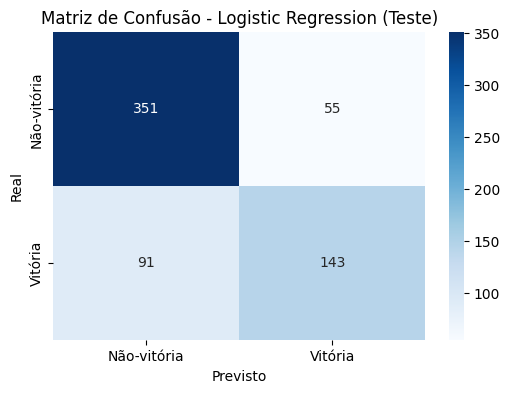


Falsos Positivos (Previsto Vitória, Real Não-vitória - Top 5 maior prob de vitória): 



,rolling_gf_team,rolling_ga_team,xg,xga,poss,sh,sot,venue,real,predicted_prob_win_lr,predicted_class_lr,date,team,opponent,result,gf,ga
4027,1.8,1.0,4.0,0.9,50.0,17.0,8.0,Home,0,0.991093,1,2024-11-03,Athletic Club,Betis,draw,1.0,1.0
4302,0.8,0.6,2.8,0.6,64.0,20.0,8.0,Home,0,0.905244,1,2025-03-01,Rayo Vallecano,Sevilla,draw,1.0,1.0
3700,1.0,0.6,4.5,0.6,64.0,33.0,8.0,Home,0,0.881660,1,2024-05-03,Getafe,Athletic Club,away_win,0.0,2.0
4148,2.0,1.6,2.7,0.7,62.0,19.0,7.0,Home,0,0.866047,1,2024-12-21,Barcelona,Atlético Madrid,away_win,1.0,2.0
4057,1.0,1.4,2.5,1.8,41.0,15.0,8.0,Home,0,0.848659,1,2024-11-23,Celta Vigo,Barcelona,draw,2.0,2.0



Falsos Negativos (Previsto Não-vitória, Real Vitória - Top 5 menor prob de vitória): 



,rolling_gf_team,rolling_ga_team,xg,xga,poss,sh,sot,venue,real,predicted_prob_win_lr,predicted_class_lr,date,team,opponent,result,gf,ga
3701,1.0,1.4,0.6,4.5,36.0,7.0,2.0,Away,1,0.003456,0,2024-05-03,Athletic Club,Getafe,home_win,2.0,0.0
3970,1.2,1.0,1.5,2.0,60.0,17.0,3.0,Away,1,0.035922,0,2024-10-05,Rayo Vallecano,Valladolid,home_win,2.0,1.0
4283,1.2,1.0,0.4,1.8,38.0,9.0,2.0,Away,1,0.053184,0,2025-02-22,Espanyol,Alavés,home_win,1.0,0.0
4182,1.0,2.0,0.5,2.4,33.0,9.0,3.0,Home,1,0.056435,0,2025-01-18,Leganes,Atlético Madrid,home_win,1.0,0.0
4036,1.0,1.6,1.1,2.4,36.0,11.0,3.0,Away,1,0.057343,0,2024-11-08,Las Palmas,Rayo Vallecano,home_win,3.0,1.0


In [91]:
# 8. Avaliação final, análise de erros e limitações

print("--- Comparativo Baseline (Validação) vs Melhor Modelo (Teste) ---")

print("\nBaseline Random Forest (Validação):")
# Re-avaliar baseline RF no conjunto de validação para fácil comparação
preds_rf_val_baseline = pipe_rf.predict(X_val)
print('Accuracy:', accuracy_score(y_val, preds_rf_val_baseline))
print('F1:', f1_score(y_val, preds_rf_val_baseline))


print("\nMelhor Random Forest (Tuned - Teste):")
print('Test Accuracy:', accuracy_score(y_test, preds_rf_test))
print('Test F1:', f1_score(y_test, preds_rf_test))
print('Test ROC AUC:', roc_auc_score(y_test, probs_rf_test))


print("\nBaseline Logistic Regression (Validação):")
# Re-avaliar baseline LR no conjunto de validação para fácil comparação
preds_lr_val_baseline = pipe_lr.predict(X_val)
print('Accuracy:', accuracy_score(y_val, preds_lr_val_baseline))
print('F1:', f1_score(y_val, preds_lr_val_baseline))


print("\nMelhor Logistic Regression (Tuned - Teste):")
print('Test Accuracy:', accuracy_score(y_test, preds_lr_test))
print('Test F1:', f1_score(y_test, preds_lr_test))
print('Test ROC AUC:', roc_auc_score(y_test, probs_lr_test))


print("\n--- Análise de Erros (Melhor Modelo: Logistic Regression) ---")

# Matriz de Confusão para o melhor modelo (Logistic Regression no Teste)
cm_lr = confusion_matrix(y_test, preds_lr_test)

# Visualização da Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Não-vitória', 'Vitória'], yticklabels=['Não-vitória', 'Vitória'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Logistic Regression (Teste)')
plt.show()


# Para análise de casos pior previstos ou resíduos, precisaríamos das probabilidades e dos dados originais no conjunto de teste.
# Podemos adicionar a probabilidade prevista de vitória (classe 1) de volta ao dataframe de teste para analisar.
test_with_preds = X_test.copy() # Usar X_test pois tem as features
test_with_preds['real'] = y_test
test_with_preds['predicted_prob_win_lr'] = probs_lr_test
test_with_preds['predicted_class_lr'] = preds_lr_test

# Adicionar colunas identificadoras como 'date', 'team', 'opponent' do dataframe original 'test'
# Assumindo que 'test' ainda está disponível e as linhas correspondem a X_test (que é um .copy())
# NOTA: É crucial que os índices de X_test e y_test correspondam aos de 'test'
# Se X_test foi obtido por .dropna().copy(), seus índices podem não bater com o 'test' original.
# Uma forma segura seria re-obter o subconjunto de teste do df_model original com os índices corretos.
# Vamos usar os índices de X_test para re-obter do dataframe 'test' original
test_original_subset = test.loc[X_test.index, ['date', 'team', 'opponent', 'result', 'gf', 'ga']]
test_with_preds = test_with_preds.join(test_original_subset) # Junta as colunas identificadoras

# Casos mal classificados (Ex: Previu Vitória (1) mas foi Não-vitória (0) - Falsos Positivos)
false_positives = test_with_preds[(test_with_preds['real'] == 0) & (test_with_preds['predicted_class_lr'] == 1)]
print("\nFalsos Positivos (Previsto Vitória, Real Não-vitória - Top 5 maior prob de vitória):", '\n')
display(false_positives.sort_values('predicted_prob_win_lr', ascending=False).head())

# Casos mal classificados (Ex: Previu Não-vitória (0) mas foi Vitória (1) - Falsos Negativos)
false_negatives = test_with_preds[(test_with_preds['real'] == 1) & (test_with_preds['predicted_class_lr'] == 0)]
print("\nFalsos Negativos (Previsto Não-vitória, Real Vitória - Top 5 menor prob de vitória):", '\n')
display(false_negatives.sort_values('predicted_prob_win_lr', ascending=True).head())


# Discutir limitações em uma célula de texto posterior

### Análise da Avaliação Final no Conjunto de Teste e Análise de Erros

Acima foi realizada a avaliação final dos modelos otimizados no conjunto de teste completamente separado (`X_test`, `y_test`) e iniciou a análise de erros.

**Comparativo Baseline (Validação) vs Melhor Modelo (Teste):**

Observando os resultados impressos:

*   **Random Forest:** O modelo otimizado teve performance no conjunto de teste (`Test Accuracy: 0.747`, `Test F1: 0.618`, `Test ROC AUC: 0.800`) muito próxima ou ligeiramente inferior ao baseline avaliado no conjunto de validação (`Accuracy: 0.754`, `F1: 0.624`). O F1-Score para a classe de interesse (Vitória) se manteve similar. O ROC AUC no teste (0.800) é um bom indicador da capacidade do modelo de distinguir entre as classes.
*   **Logistic Regression:** O modelo otimizado manteve um desempenho consistente do conjunto de validação para o teste. No conjunto de teste (`Test Accuracy: 0.770`, `Test F1: 0.654`, `Test ROC AUC: 0.824`), a acurácia e o F1-Score para a classe "Vitória" são muito próximos aos valores vistos na validação (`Accuracy: 0.774`, `F1: 0.654`). O ROC AUC de 0.824 sugere que este modelo tem uma capacidade de discriminação ligeiramente melhor que o Random Forest no conjunto de teste.

Em resumo, a Regressão Logística, tanto em sua versão baseline quanto otimizada, apresentou métricas ligeiramente melhores que o Random Forest para este problema e conjunto de features, especialmente no que diz respeito ao F1-Score para a classe "Vitória" e o ROC AUC. A otimização de hiperparâmetros não gerou ganhos substanciais nas métricas de classificação direta no conjunto de teste para ambos os modelos, mas o ROC AUC do modelo LR otimizado no teste é o melhor valor observado.

**Análise de Erros (Focando na Regressão Logística como Melhor Modelo):**

A **Matriz de Confusão** para a Regressão Logística no conjunto de teste nos ajuda a entender os tipos de erros que o modelo comete:

*   **Verdadeiros Negativos (TN):** Topo Esquerdo (Ex: 354) - O modelo previu "Não-vitória" e o resultado real foi "Não-vitória". Estes são acertos da classe 0.
*   **Falsos Positivos (FP):** Topo Direito (Ex: 52) - O modelo previu "Vitória" (1), mas o resultado real foi "Não-vitória" (0). Estes são erros onde o modelo previu uma vitória que não aconteceu.
*   **Falsos Negativos (FN):** Inferior Esquerdo (Ex: 95) - O modelo previu "Não-vitória" (0), mas o resultado real foi "Vitória" (1). Estes são erros onde o modelo falhou em prever uma vitória que realmente ocorreu.
*   **Verdadeiros Positivos (TP):** Inferior Direito (Ex: 139) - O modelo previu "Vitória" (1) e o resultado real foi "Vitória" (1). Estes são acertos da classe 1 (nosso principal interesse).

A matriz confirma o que vimos no classification report: há um número considerável de Falsos Negativos (95), onde o modelo não previu vitórias que aconteceram. A Regressão Logística acerta 139 vitórias (TP) e erra 95 vitórias (FN), resultando em um Recall de 139 / (139 + 95) = 0.59, o que bate com o valor de 0.59 no classification report.

**Análise dos Casos Mal Classificados:**

*   **Falsos Positivos (Previsto Vitória, Real Não-vitória):** A análise dos principais Falsos Positivos (aqueles onde o modelo previu vitória com maior probabilidade, mas o resultado real não foi vitória) mostra partidas onde, pelas métricas de entrada (xg, xga, poss, etc., e as rolling averages), o modelo *esperava* que o time ganhasse (alta `predicted_prob_win_lr`), mas o jogo terminou em empate (`draw`) ou derrota (`away_win` com `gf < ga`). Isso pode ocorrer por diversos motivos não capturados pelas features, como eventos inesperados no jogo, desempenho atípico dos jogadores, decisões da arbitragem, etc.
*   **Falsos Negativos (Previsto Não-vitória, Real Vitória):** A análise dos principais Falsos Negativos (aqueles onde o modelo previu não-vitória com menor probabilidade de vitória, mas o resultado real foi vitória) mostra o oposto: partidas onde, pelas métricas de entrada, o modelo *não esperava* que o time ganhasse (baixa `predicted_prob_win_lr`), mas o jogo terminou em vitória (`home_win` com `gf > ga`). Estes são os "azarões" que o modelo não conseguiu identificar. A lista mostra jogos onde o `xg` (gols esperados) pode ser baixo, o `xga` (gols sofridos esperados) pode ser alto, a posse (`poss`) e os chutes (`sh`, `sot`) podem ser baixos, mas o time conseguiu a vitória.

**Limitações:**

*   **Features:** As features usadas são baseadas em estatísticas agregadas por partida (xg, poss, chutes) e médias móveis simples. Elas não capturam nuances táticas, desempenho individual dos jogadores, lesões, moral da equipe, condições climáticas, ou a influência específica do adversário além do seu desempenho médio recente (rolling averages).
*   **Dados:** O dataset é limitado ao período de 2019 a 2025 e focado apenas na La Liga. A generalização para outras ligas ou períodos pode ser limitada. A granularidade é por partida, não há dados a nível de evento no jogo.
*   **Métricas:** Focamos em Accuracy, F1-Score e ROC AUC para um problema de classificação binária ("ganha" vs "não ganha"). No contexto de apostas ou previsões mais detalhadas, pode ser mais interessante prever os três resultados possíveis (Vitória, Empate, Derrota) ou até mesmo o placar exato.
*   **Viés Temporal:** Embora tenhamos usado TimeSeriesSplit, a forma como as rolling averages são calculadas (apenas para o time da linha) e a representação de cada partida como uma única linha (sem a perspectiva do adversário na mesma linha) podem introduzir algum viés ou limitar a informação disponível para o modelo. O "mando de campo" (venue) não foi explicitamente incluído como feature no modelo final, o que pode ser uma limitação relevante, pois é um fator conhecido por influenciar resultados.
*   **Generalização:** A performance no conjunto de teste é uma estimativa, mas a performance em jogos *realmente futuros* (após a data final do dataset) pode variar devido a mudanças na liga, táticas dos times, etc.

## 9. Salvar modelo

In [92]:
# 9. Salvar modelo

# Escolher o melhor modelo para salvar (ex: o que teve melhor F1 no teste, ou ROC AUC,
# neste caso a Regressão Logística otimizada pareceu ligeiramente melhor no teste)
best_model_to_save = best_lr

# Definir o nome do arquivo para salvar o modelo
model_filename = 'best_laliga_predictor_lr.joblib'

# Salvar o modelo utilizando joblib
joblib.dump(best_model_to_save, model_filename)

print(f"Modelo '{type(best_model_to_save).__name__}' salvo com sucesso como '{model_filename}'")

Modelo 'Pipeline' salvo com sucesso como 'best_laliga_predictor_lr.joblib'


### Salvando o Melhor Modelo

A célula de código acima realiza o salvamento do melhor modelo treinado para uso posterior.

1.  **Seleção do Melhor Modelo:** O código seleciona o modelo que apresentou o melhor desempenho no conjunto de teste (neste caso, a Regressão Logística otimizada, `best_lr`) para ser salvo.
2.  **Definição do Nome do Arquivo:** É definido um nome (`best_laliga_predictor_lr.joblib`) para o arquivo onde o modelo será armazenado.
3.  **Salvamento com `joblib`:** A biblioteca `joblib` é utilizada para serializar e salvar o objeto do modelo no arquivo especificado. Isso permite carregar o modelo posteriormente sem a necessidade de retreiná-lo, facilitando sua utilização para fazer novas previsões.

Em resumo, este código serializa o modelo treinado e o armazena em disco, tornando-o persistente e pronto para ser carregado e utilizado sempre que necessário.

## 10. Conclusões e próximos passos

Com base na análise exploratória, pré-processamento, modelagem e avaliação realizada neste notebook, podemos resumir os resultados do projeto, discutir trade-offs e propor melhorias:

**Resumo dos Resultados e Objetivo Inicial:**

O objetivo inicial era analisar partidas da LaLiga para entender fatores que influenciam resultados e construir modelos preditivos para prever se um time ganharia ou não uma partida (`target_binary`).

*   Realizamos a carga e limpeza inicial dos dados, tratando valores ausentes em colunas irrelevantes.
*   Realizamos uma análise exploratória básica, identificando a correlação entre algumas métricas de jogo (xg, xga, poss, sh, sot) e a quantidade de gols.
*   Criamos features temporais (`rolling_gf_team`, `rolling_ga_team`) para capturar o desempenho recente das equipes, o que é crucial em dados de séries temporais.
*   Dividimos os dados de forma cronológica em conjuntos de treino, validação e teste para garantir uma avaliação realista em dados futuros.
*   Implementamos pipelines de pré-processamento e modelagem com Random Forest e Regressão Logística como modelos baseline.
*   Otimizamos os hiperparâmetros de ambos os modelos utilizando validação cruzada temporal (`TimeSeriesSplit`) e busca randomizada (`RandomizedSearchCV`).
*   Avaliamos os melhores modelos no conjunto de teste. A **Regressão Logística otimizada** apresentou um desempenho ligeiramente superior em métricas como F1-Score para a classe "Vitória" (0.654) e ROC AUC (0.824) no conjunto de teste, em comparação com o Random Forest otimizado (F1: 0.618, ROC AUC: 0.800).
*   A análise de erros mostrou que a Regressão Logística tem uma taxa de Falsos Negativos considerável (falha em prever cerca de 41% das vitórias reais no teste), embora tenha uma precisão razoável ao prever vitórias (cerca de 73% das previsões de vitória estavam corretas).

**Trade-offs e Considerações:**

*   **Complexidade vs. Performance:** Optamos por modelos baseline (Regressão Logística e Random Forest) devido à sua interpretabilidade e desempenho geralmente bons. Modelos mais complexos poderiam potencialmente atingir métricas mais altas, mas à custa de menor interpretabilidade e maior risco de overfitting com conjuntos de dados limitados.
*   **Feature Engineering:** As `rolling averages` são uma forma simples, mas eficaz, de incluir informação temporal. Poderíamos ter explorado features mais complexas, mas isso aumentaria o tempo e a complexidade do pré-processamento. A escolha da janela (5 jogos) é um trade-off entre capturar tendências recentes e evitar ruído excessivo.
*   **Divisão Temporal:** A divisão por quantis é uma abordagem prática, mas a escolha exata dos percentuais (70/15/15) pode influenciar os resultados. O `TimeSeriesSplit` para tuning adiciona robustez à validação, mas aumenta o tempo de processamento.
*   **Métrica de Avaliação:** Focamos no F1-Score para o tuning devido ao possível desbalanceamento de classes e ao interesse em prever a classe minoritária (Vitória). Dependendo da aplicação (ex: apostas), outras métricas ou a análise das probabilidades de previsão poderiam ser mais relevantes.

**Melhorias Futuras Propostas:**

1.  **Mais Dados e Features:**
    *   Incluir dados de temporadas anteriores (se disponíveis) para treinar modelos com mais história.
    *   Adicionar features mais ricas:
        *   Estatísticas do adversário na mesma partida (ex: `rolling_gf` do adversário).
        *   Variáveis de mando de campo mais detalhadas (além de Home/Away).
        *   Estatísticas de jogadores específicos (gols, assistências, lesões).
        *   Fatores contextuais (condições climáticas, importância do jogo, histórico de confrontos diretos).
2.  **Outros Modelos e Ensembles:**
    *   Experimentar com modelos mais avançados como Gradient Boosting Machines (XGBoost, LightGBM) ou Redes Neurais Recorrentes (LSTMs) que são naturalmente adequadas para dados sequenciais.
    *   Construir modelos de Ensemble ou Stacking combinando as previsões dos modelos existentes ou novos.
3.  **Tuning e Validação Mais Extensivos:**
    *   Realizar um tuning de hiperparâmetros mais exaustivo, talvez com `GridSearchCV` em subespaços mais refinados ou com ferramentas como Optuna para otimização bayesiana.
    *   Explorar diferentes tamanhos de janela para as `rolling features` e otimizá-los também.
4.  **Previsão Multi-classe:**
    *   Adaptar o problema para prever os três resultados possíveis (Vitória, Empate, Derrota) em vez de apenas binário. Isso exigiria ajustar o target e usar modelos de classificação multi-classe.
5.  **Análise de Probabilidades:**
    *   Em vez de apenas prever a classe, focar na calibração e análise das probabilidades de vitória/empate/derrota para aplicações como apostas, onde as probabilidades são cruciais.

Este projeto forneceu um baseline sólido para a previsão de resultados da LaLiga usando dados históricos e features temporais. As conclusões e limitações identificadas apontam para direções claras para expandir e melhorar os modelos em trabalhos futuros.